# Calculate spatial averages with xweights

In [1]:
import xweights as xw

Let's have a look whihc regions are already available.

In [2]:
xw.which_regions()

{'counties': 'Counties (Landkreise) from Germany.',
 'states': 'States (Bundesländer) from Germany',
 'prudence': 'PRUDENCE regions'}

We use the counties from Germany and select "Konstanz".

In [3]:
for name in list(xw.which_subregions("counties").values())[0]:
    if "Konstanz" in name:
        print(name)

08335_Konstanz


In [4]:
shp = xw.get_region("counties", name="08335_Konstanz")
shp = shp.rename(index={0: "Konstanz"})
shp

,ADE,ARS,ARS_0,GEN,geometry,name
Konstanz,4,08335,083350000000,Konstanz,"MULTIPOLYGON (((8.66981 47.68563, 8.66567 47.6...",08335_Konstanz


<AxesSubplot:>

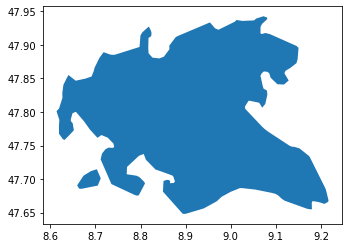

In [5]:
shp.plot()

Open test netCDF file 

In [6]:
ncfile = "/work/ch0636/eddy/pool/sims/cordex/euro-cordex/esgf/EUR11/day/climdex/v2.0/rr95p/RR95p_EUR-11_NCC-NorESM1-M_rcp26_r1i1p1_GERICS-REMO2015_v1_day_GERICS-climdex-v2.0_year_1951-2100.nc"

In [7]:
from pyhomogenize import open_xrdataset

In [8]:
ds = open_xrdataset(ncfile)
ds

<xarray.Dataset>
Dimensions:                     (time: 150, bnds: 2, rlat: 412, rlon: 424,
                                 vertices: 4)
Coordinates:
  * time                        (time) object 1951-07-02 12:00:00 ... 2100-07...
    lon                         (rlat, rlon) float32 dask.array<chunksize=(412, 424), meta=np.ndarray>
    lat                         (rlat, rlon) float32 dask.array<chunksize=(412, 424), meta=np.ndarray>
  * rlon                        (rlon) float64 -28.38 -28.27 ... 18.04 18.16
  * rlat                        (rlat) float64 -23.38 -23.27 ... 21.72 21.84
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds                   (time, bnds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    lon_bnds                    (rlat, rlon, vertices) float32 dask.array<chunksize=(412, 424, 4), meta=np.ndarray>
    lat_bnds                    (rlat, rlon, vertices) float32 dask.array<chunksize=(412, 424, 4), meta=np.ndarray>
    rotated_latitude_longitude  int32 ...
    RR95p                       (time, rlat, rlon) float32 dask.array<chunksize=(1, 412, 424), meta=np.ndarray>
Attributes: (12/46)
    history:                        Fri May 28 14:25:29 2021: cdo -O -yearpct...
    source:                         GERICS-REMO2015
    institution:                    Helmholtz-Zentrum Geesthacht, Climate Ser...
    Conventions:                    CF-1.4
    institute_id:                   GERICS
    experiment_id:                  historical
    ...                             ...
    ci_product:                     rcm_derived
    ci_frequency:                   year
    ci_timerange_index:             1951-2100
    ci_timerange_source:            19500102-21001231
    ci_package_reference:           Climate Data Operators version 1.9.8 (htt...
    CF_variables:                   ['RR95p']

Select time slices and merge to one dataset.

In [9]:
ds_nf = ds.sel(time=slice("2011", "2040"))
ds_mf = ds.sel(time=slice("2041", "2070"))
ds_ff = ds.sel(time=slice("2071", "2100"))

In [10]:
ds_nf_mean = ds_nf.mean("time").assign_coords({"time": "near-future"})
ds_nf_mean["RR95p"] = ds_nf_mean["RR95p"].expand_dims("time")
ds_mf_mean = ds_mf.mean("time").assign_coords({"time": "middle-future"})
ds_mf_mean["RR95p"] = ds_mf_mean["RR95p"].expand_dims("time")
ds_ff_mean = ds_ff.mean("time").assign_coords({"time": "far-future"})
ds_ff_mean["RR95p"] = ds_ff_mean["RR95p"].expand_dims("time")

In [11]:
import xarray as xr

ds_mean = xr.merge([ds_nf_mean, ds_mf_mean, ds_ff_mean])
ds_mean

<xarray.Dataset>
Dimensions:                     (rlon: 424, rlat: 412, time: 3, vertices: 4)
Coordinates:
  * rlon                        (rlon) float64 -28.38 -28.27 ... 18.04 18.16
  * rlat                        (rlat) float64 -23.38 -23.27 ... 21.72 21.84
  * time                        (time) <U13 'far-future' ... 'near-future'
    lon                         (rlat, rlon) float32 dask.array<chunksize=(412, 424), meta=np.ndarray>
    lat                         (rlat, rlon) float32 dask.array<chunksize=(412, 424), meta=np.ndarray>
Dimensions without coordinates: vertices
Data variables:
    lon_bnds                    (rlat, rlon, vertices) float32 dask.array<chunksize=(412, 424, 4), meta=np.ndarray>
    lat_bnds                    (rlat, rlon, vertices) float32 dask.array<chunksize=(412, 424, 4), meta=np.ndarray>
    rotated_latitude_longitude  float64 1.0
    RR95p                       (time, rlat, rlon) float32 dask.array<chunksize=(3, 412, 424), meta=np.ndarray>

Calculate spatial averages for Konstanz

In [12]:
df = xw.compute_weighted_means_ds(
    ds_mean,
    shp=shp,
    ds_name="RR95p_EUR-11_NCC-NorESM1-M_rcp26_r1i1p1_GERICS-REMO2015_v1_day_GERICS-climdex-v2.0_year_1951-2100",
)

In [13]:
df

,,lon,lat,name,nnz,RR95p
time,geom,,,,,
far-future,Konstanz,8.917877,47.792187,RR95p_EUR-11_NCC-NorESM1-M_rcp26_r1i1p1_GERICS...,12,20.931541
middle-future,Konstanz,8.917877,47.792187,RR95p_EUR-11_NCC-NorESM1-M_rcp26_r1i1p1_GERICS...,12,21.499170
near-future,Konstanz,8.917877,47.792187,RR95p_EUR-11_NCC-NorESM1-M_rcp26_r1i1p1_GERICS...,12,20.319889


**nnz** is the number of used grid cells. **nnz** > 4.